<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230416_v6_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline 

In [3]:
# import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [4]:
sm.__version__

'1.0.1'

In [5]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteB1VCG4/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteB1VCG4/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')

Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [7]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [8]:
img_height = 128
img_width = 128

In [9]:
# Function to resize images and segmentation masks
# subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def resize_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_mask -= 1

  return input_image, input_mask

In [10]:
train_dataset = dataset[0].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [12]:
# Creat train numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# train images
X_train = np.zeros(shape=(3000,128,128,3)) 
# train masks
Y_train = np.zeros(shape=(3000,128,128,1))

idx = 0
for img,mask in train_dataset.take(3000):
    X_train[idx] = img
    Y_train[idx] = mask
    idx += 1

  

In [13]:
# Values for X_train
print(np.unique(X_train[0]))

[0.00000000e+00 2.44140625e-04 1.70898438e-03 ... 1.99236572e+02
 1.99903076e+02 2.01921875e+02]


In [14]:

max = X_train[1].max()
min = X_train[1].min()
mean = X_train[1].mean()
median = np.percentile(X_train[1],50)
print(f'Mean: {mean}\tMedian: {median}')
print(f'Min.: {min}\t\t\tMax.: {max}')

Mean: 98.12961354975899	Median: 83.94992065429688
Min.: 0.0			Max.: 255.0


In [15]:
# Values for Y_train mask
np.unique(Y_train[1000])

array([0., 1., 2.])

In [16]:
# Creat val numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# val images
X_val = np.zeros(shape=(300,128,128,3)) 
# val masks
Y_val = np.zeros(shape=(300,128,128,1))

i = 0
for img,mask in train_dataset.skip(3000).take(300):
    X_val[i] = img
    Y_val[i] = mask
    i += 1

In [17]:
len(Y_val)

300

In [18]:
# Display image, repective mask and model prediction 
def display(data_list,divide=255):
  plt.figure(figsize=(12,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i]/divide)
    plt.axis('off')
  plt.show()



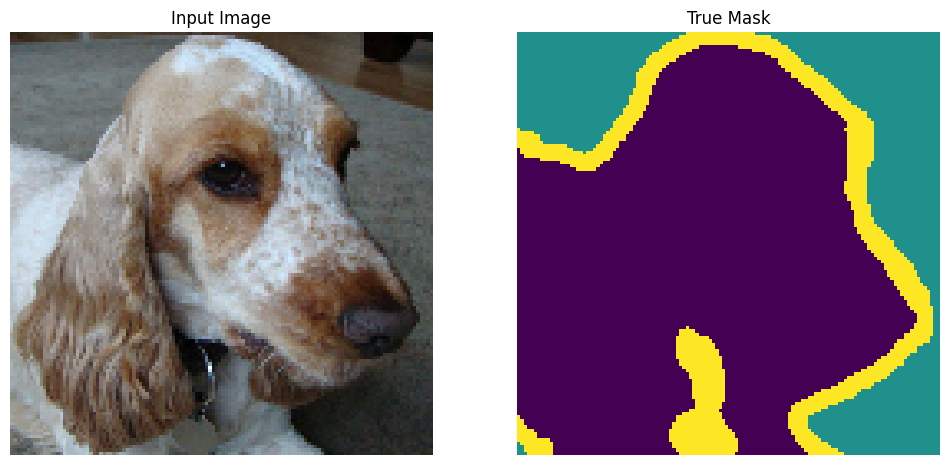

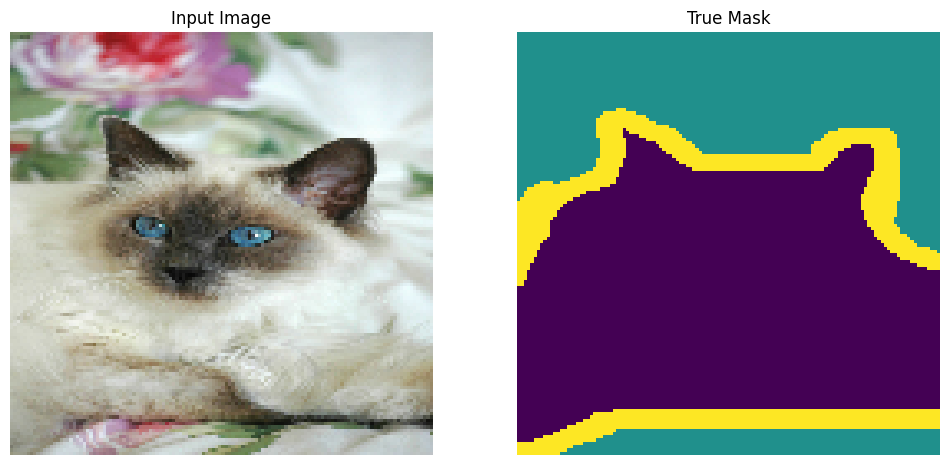

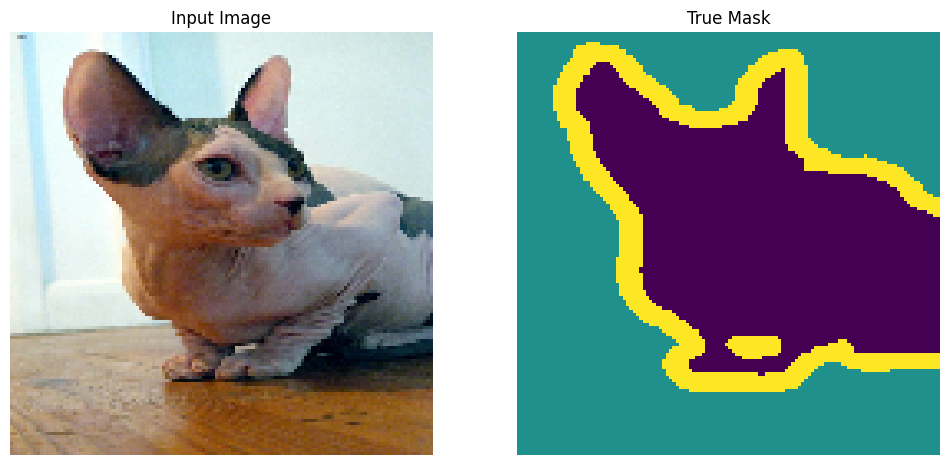

In [19]:
# Randomly select an image and its respective mask 3 times for display
for i in range(3):
  num = np.random.randint(0,3000)
  display([X_train[num],Y_train[num]])

In [20]:
print(f'Shape of X_train: {X_train.shape}\tData type: {type(X_train)}')
print(f'Shape of Y_train: {Y_train.shape}\tData type: {type(Y_train)}')
print(f'Shape of X_val: {X_val.shape}\tData type: {type(X_val)}')
print(f'Shape of Y_val: {Y_val.shape}\tData type: {type(Y_val)}')

Shape of X_train: (3000, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_train: (3000, 128, 128, 1)	Data type: <class 'numpy.ndarray'>
Shape of X_val: (300, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_val: (300, 128, 128, 1)	Data type: <class 'numpy.ndarray'>


In [21]:
pd.Series(Y_train[2500].flatten(order='C')).value_counts().sort_index().index.tolist()

[0.0, 1.0, 2.0]

In [21]:
class_distribution = []
image_numbers = []
while len(image_numbers) < 1000:
  num = np.random.randint(0,len(Y_train))
  if num not in image_numbers:
    mask_copy = Y_train[num].copy()
    mask = pd.Series(mask_copy.flatten(order='C'))
    if len(mask) == (128*128):
      image_numbers.append(num)
      class_distribution.append([mask.value_counts().sort_index()/(128*128)])
    if len(image_numbers) % 50 == 0:
      print(f'Percent completed: {len(image_numbers)/1000*100}') 



Percent completed: 5.0
Percent completed: 10.0
Percent completed: 15.0
Percent completed: 20.0
Percent completed: 25.0
Percent completed: 30.0
Percent completed: 35.0
Percent completed: 40.0
Percent completed: 45.0
Percent completed: 50.0
Percent completed: 55.00000000000001
Percent completed: 60.0
Percent completed: 65.0
Percent completed: 70.0
Percent completed: 75.0
Percent completed: 80.0
Percent completed: 85.0
Percent completed: 90.0
Percent completed: 95.0
Percent completed: 100.0


In [22]:
class_0 = 0
class_1 = 0
class_2 = 0
for val in class_distribution:
  if len(val[0].values) == 3:
    class_0 =+ val[0].values[0]
    class_1 =+ val[0].values[1]
    class_2 =+ val[0].values[2]
  

In [25]:
class_0_distribution = class_0.mean()
class_1_distribution = class_1.mean()
class_2_distribution = class_2.mean()
print(f'Average distribution for class 0: {class_0_distribution}.')
print(f'Average distribution for class 1: {class_1_distribution}.')
print(f'Average distribution for class 2: {class_2_distribution}.')

Average distribution for class 0: 0.03936767578125.
Average distribution for class 1: 0.913818359375.
Average distribution for class 2: 0.04681396484375.


In [25]:
# Convert masks/labels to categorical (onehot encode)
#Y_train_cat = to_categorical(Y_train,num_classes=3)
#Y_val_cat = to_categorical(Y_val, num_classes=3)


In [26]:
#print(f'Y_train_cat.shape: {Y_train_cat.shape}')
#print(f'Y_val_cat.shape: {Y_val_cat.shape}')


In [26]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

In [27]:
p_max = X_train_p[1].max()
p_min = X_train_p[1].min()
p_mean = X_train_p[1].mean()
p_median = np.percentile(X_train_p[1],50)
print(f'Mean: {p_mean}\tMedian: {p_median}')
print(f'Min.: {p_min}\t\t\tMax.: {p_max}')

Mean: -16.66971978357434	Median: -29.346867431640618
Min.: -123.68			Max.: 151.061


Image number: 1162


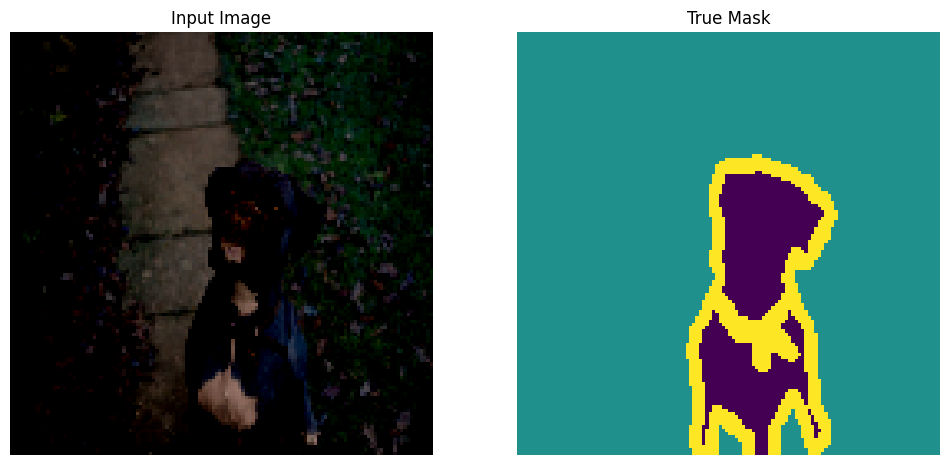

In [28]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask])

In [29]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [30]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = current_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(current_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 20ms/step


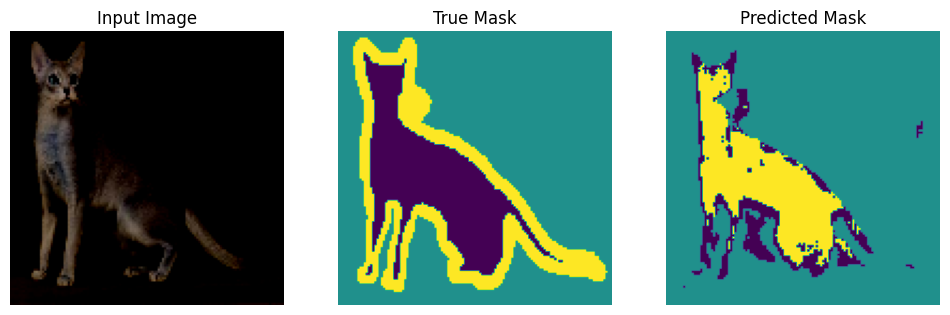

In [49]:
show_predictions()

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [38]:

# define model
n_classes = 3
activation='elu'

model_1 = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1

In [ ]:
#for idx,layer in enumerate(model.layers):
#  print(f'Layer number: {idx} ==> {layer}')


In [39]:
LR = 0.0001
optimizer_input = keras.optimizers.Adam(LR)
#optimizer_input = tf.keras.optimizers.SGD(LR)

#loss_input = sm.losses.DiceLoss(class_weights=[0.35,0.5,0.15])
#loss_input = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1*focal_loss)
#loss_input = total_loss
loss_input = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_input = sm.losses.JaccardLoss(class_weights=[0.35,0.5,0.15])

#metrrics_input = [tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred = False)]
#metrrics_input = ['accuracy']
metrics_input = [tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred = False)]


In [40]:
model_1.compile(optimizer=optimizer_input,
              loss=loss_input,
              metrics=metrics_input)

In [41]:
earlystopper = EarlyStopping(patience=3, verbose=1)
callback_list = [earlystopper,DisplayCallback()]

In [42]:
model_1.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [39]:
#tf.keras.utils.plot_model(model, show_shapes=True)
#len(model.layers)

1/1 [==============================] - 0s 23ms/step


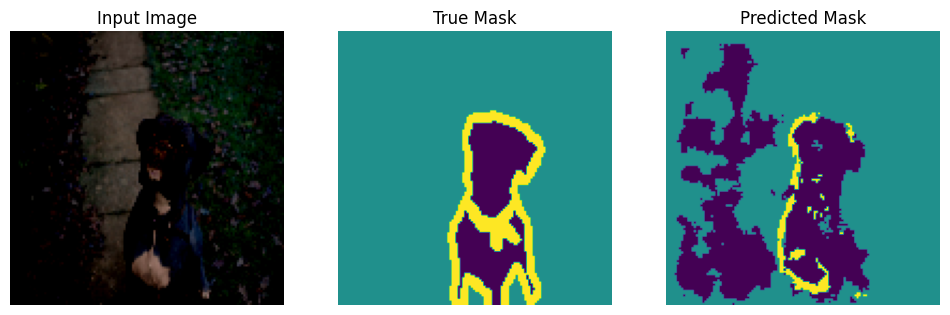


Sample Prediction after epoch 5

60/60 [==============================] - 13s 214ms/step - loss: 0.5569 - mean_io_u_1: 0.5182 - val_loss: 0.5411 - val_mean_io_u_1: 0.5102


In [43]:
# Pre-train model
history=model_1.fit(X_train_p, 
          Y_train,
          batch_size=50, 
          epochs=5,
          verbose=1,
          validation_data=(X_val_p,Y_val),
          callbacks=callback_list)

In [44]:
model_1.trainable = True

In [47]:
#model.summary()

1/1 [==============================] - 0s 21ms/step


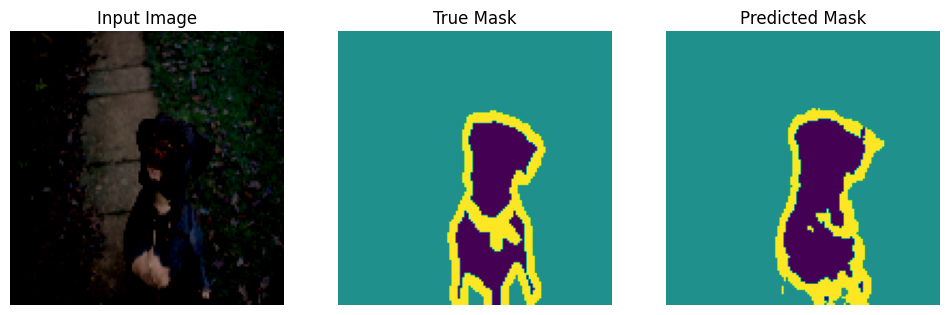


Sample Prediction after epoch 18

60/60 [==============================] - 13s 217ms/step - loss: 0.1724 - mean_io_u_1: 0.7979 - val_loss: 0.2764 - val_mean_io_u_1: 0.7225
Epoch 18: early stopping


In [45]:
history=model_1.fit(X_train_p, 
          Y_train,
          batch_size=50, 
          epochs=50,
          verbose=1,
          validation_data=(X_val_p,Y_val),
          callbacks=callback_list)

In [47]:
np.random.seed(123)
test_image_number = np.random.randint(0,len(X_val))
test_img = X_val_p[test_image_number]
ground_truth = Y_val[test_image_number]

test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

test_pred = model_1.predict(test_img_input)

test_prediction = np.argmax(test_pred, axis=3)[0,:,:]


1/1 [==============================] - 0s 19ms/step


<Figure size 1200x800 with 0 Axes>

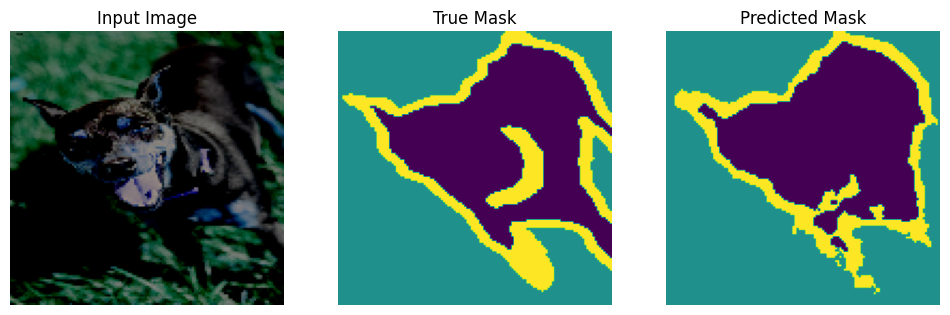

In [49]:
plt.figure(figsize=(12, 8))
display([test_img,ground_truth,test_prediction])
plt.show()


In [50]:
history.history.keys()

dict_keys(['loss', 'mean_io_u_1', 'val_loss', 'val_mean_io_u_1'])

In [51]:
def show_history(model_history):
  
  var = list(history.history.keys())
  #acc = model_history.history['accuracy']
  #val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  iou = model_history.history[var[1]]
  val_iou = model_history.history[var[-1]]
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))

  #plt.subplot(1,3,1)
  #plt.plot(epochs_range, acc, label='Training Accuracy')
  #plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  #plt.legend(loc='lower right')
  #plt.title('Training and Validation Accuracy')


  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, iou, label='Training MeanIoU')
  plt.plot(epochs_range, val_iou, label='Validation MeanIoU')

  plt.legend(loc='lower right')
  plt.title('Training and Validation IoU')
  plt.show()

  #train_acc = model_history.history['accuracy'][-1]
  #val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[2]][-1]
  val_meanIoU = model_history.history[var[-1]][-1]

  print(f'Training loss: {train_loss:.3f}\tTraining meanIoU: {train_meanIoU:.3f}')
  print(f'Validation loss: {val_loss:.3f}\tValidation meanIoU: {val_meanIoU:.3f}')
  


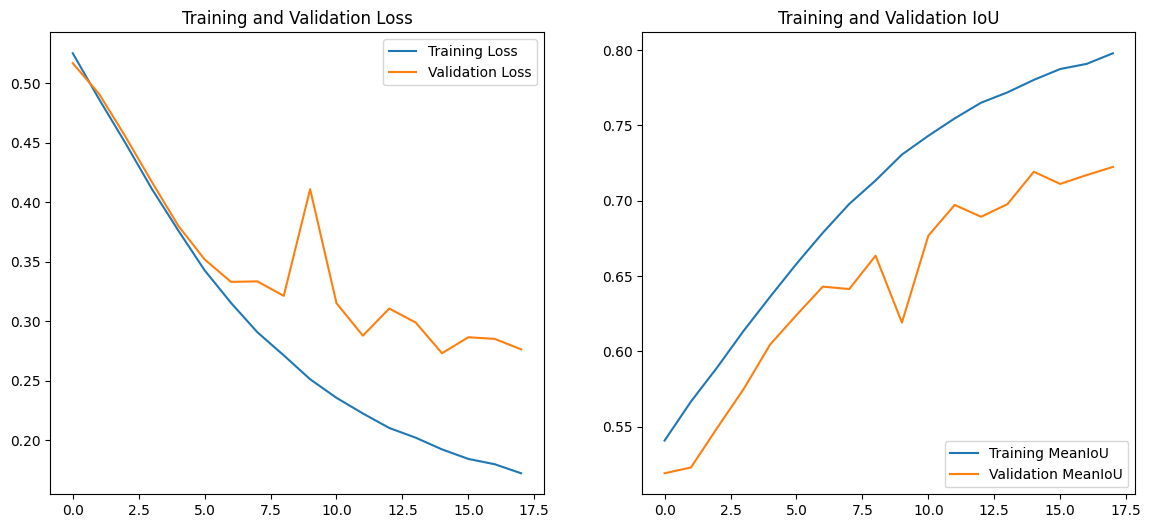

Training loss: 0.172	Training meanIoU: 0.276
Validation loss: 0.276	Validation meanIoU: 0.722


In [52]:
show_history(history)